In [1]:
import matplotlib
import numpy as np
from scipy import arange
matplotlib.use('AGG') 
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### Find all n combinations of Feature Sets

In [105]:
# List of all feature sets
# n is the number of combinations out of all the feature names
n = 4
feature_names = ["ResNetfc1000","VGGNetfc6","VGGNetfc7","VGGNetfc8","AlexNetfc6","AlexNetfc7","AlexNetfc8","CaffeNetfc6","CaffeNetfc7","CaffeNetfc8","GoogleNetloss3"]
all_names = list(itertools.combinations(feature_names,n)) #specify how many feature set combinations you want
len(all_names)

330

In [ ]:
# Concatenates those feature sets then does nearest neighbours
total_acc = []
total_std = []
for j in range(len(all_names)):
    image_features = np.genfromtxt('Features Extracted/UCMerced/'+all_names[j][0]+ '.csv', delimiter=',')
    for i in range(1,len(all_names[j])):
        temp = np.genfromtxt('Features Extracted/UCMerced/'+all_names[j][i]+ '.csv', delimiter=',')
        image_features = np.concatenate((image_features,temp),axis=1)
    #Nearest Neighbours on all images LOOCV
    lin = range(0,image_features.shape[0],100)
    acc = np.zeros((len(lin)))
    for a in range(len(lin)):
        x = np.linalg.norm((image_features[lin[a],:] - image_features),axis=1)
        y = np.sort(x)
        sort_index = np.argsort(x)
        d = y[0:100]
        idx = sort_index[0:100]
        target = range(lin[a],lin[a]+100)
        inter = np.intersect1d(target[1:],idx[1:])
        acc[a] = inter.shape[0]/99.0
    total_acc.append(np.mean(acc))
    total_std.append(np.std(acc))

In [74]:
best_names = []

In [108]:
best_names.append(all_names)
#best_names

In [107]:
print len(total_acc)
print len(total_std)

330
330


In [77]:
all_acc = []
all_std = []

In [109]:
all_acc.extend(total_acc)
all_std.extend(total_std)

In [110]:
print len(all_acc)
print len(all_std)

561
561


In [69]:
np.savetxt("Features Extracted/Kaggle validation/Concat/allstd.csv", all_std, delimiter=",")

In [2]:
#Best Feature set conatenated together, did it again on test set. Again make nearest neighbours into module
feature_names = ["ResNetfc1000","VGGNetfc7","AlexNetfc8","CaffeNetfc7"]
total_acc = []
total_std = []
image_features = np.genfromtxt('Features Extracted/Kaggle validation/'+feature_names[0]+ '.csv', delimiter=',')
for i in range(1,len(feature_names)):
    temp = np.genfromtxt('Features Extracted/Kaggle validation/'+feature_names[i]+ '.csv', delimiter=',')
    image_features = np.concatenate((image_features,temp),axis=1)
#Nearest Neighbours on all images LOOCV
lin = range(0,image_features.shape[0],5)
acc = np.zeros((len(lin)))
for a in range(len(lin)):
    x = np.linalg.norm((image_features[lin[a],:] - image_features),axis=1)
    y = np.sort(x)
    sort_index = np.argsort(x)
    d = y[0:5]
    idx = sort_index[0:5]
    target = range(lin[a],lin[a]+5)
    inter = np.intersect1d(target[1:],idx[1:])
    acc[a] = inter.shape[0]/4.0
total_acc.append(np.mean(acc))
total_std.append(np.std(acc))

In [252]:
total_acc = []
total_std = []

### Feature subselection: Chosing Random Features

For Feature subselection. Randomly chose features based on a uniform distribution and see how it turned out for nearest neighbours evaluation.

In [356]:
#Choosing random features from a uniform distribution and evaluating
n = np.random.randint(1,10192,size=2100)
image_random = image_features[:,n]
#Nearest Neighbours on all images LOOCV
lin = range(0,image_random.shape[0],5)
acc = np.zeros((len(lin)))
for a in range(len(lin)):
    x = np.linalg.norm((image_random[lin[a],:] - image_random),axis=1)
    y = np.sort(x)
    sort_index = np.argsort(x)
    d = y[0:5]
    idx = sort_index[0:5]
    target = range(lin[a],lin[a]+5)
    inter = np.intersect1d(target[1:],idx[1:])
    acc[a] = inter.shape[0]/4.0
total_acc.append(np.mean(acc))
total_std.append(np.std(acc))

In [357]:
len(total_acc) #Ran above cell 100 times

100

In [358]:
#For getting a confidence interval
from scipy import stats
confidence=0.95
total_acc
n = len(total_acc)
m, se = np.mean(total_acc), stats.sem(total_acc)
h = se * stats.t._ppf((1+confidence)/2., n-1)
print m,m-h,m+h

0.65315 0.650688721741 0.655611278259


### Feature subselection for Random Forest

In [13]:
#Make target labels for random forest
y = lin*5
y.sort()

In [80]:
#Random forest for random feature subselection
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=250,random_state=0)
forest.fit(image_features, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [246]:
#Evaluating random forest feature subselection
total_acc = []
total_std = []
for i in range(100,len(indices),500):
    image_ra = image_features[:,indices[0:i]]
    #Nearest Neighbours on all images LOOCV
    lin = range(0,image_ra.shape[0],5)
    acc = np.zeros((len(lin)))
    for a in range(len(lin)):
        x = np.linalg.norm((image_ra[lin[a],:] - image_ra),axis=1)
        y = np.sort(x)
        sort_index = np.argsort(x)
        d = y[0:5]
        idx = sort_index[0:5]
        target = range(lin[a],lin[a]+5)
        inter = np.intersect1d(target[1:],idx[1:])
        acc[a] = inter.shape[0]/4.0
    total_acc.append(np.mean(acc))
    total_std.append(np.std(acc))

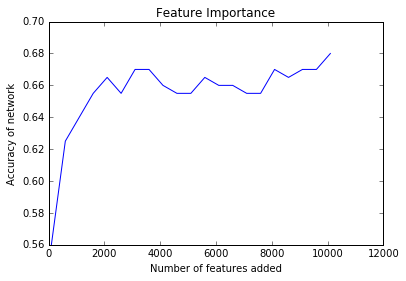

In [247]:
#If adding features from random forest how much does accuracy improve
x = range(100,len(indices),500)
plt.plot(x,total_acc)
plt.xlabel('Number of features added')
plt.ylabel('Accuracy of network')
plt.title('Feature Importance')

In [371]:
#Used for plot below, plot which features important from which feature set R=res,V=vgg,C=caffe,A=alex
R = np.array(range(0,1000))
V = np.array(range(1000,5096))
A = np.array(range(5096,6096))
C = np.array(range(6096,10192))
test = np.concatenate((R,V,A,C))

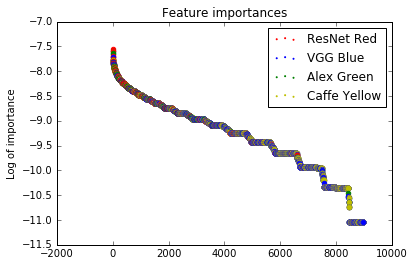

In [391]:
for y in range(len(indices)):
    if indices[y] in R:
        p1 = plt.scatter(y,np.log(importances[indices[y]]),color='r')
    if indices[y] in V:
        p2= plt.scatter(y,np.log(importances[indices[y]]),color='b')
    if indices[y] in A:
        p3 = plt.scatter(y,np.log(importances[indices[y]]),color='g')
    if indices[y] in C:
        p4 = plt.scatter(y,np.log(importances[indices[y]]),color='y')
plt.title("Feature importances")
plt.legend([p1,p2,p3,p4],["ResNet Red", "VGG Blue","Alex Green","Caffe Yellow"])
plt.ylabel("Log of importance")
plt.show()

In [19]:
#np.savetxt("Features Extracted/Kaggle validation/Concat/RV7A8C7.csv", image_features, delimiter=",")